<https://blog.csdn.net/ReadAir/article/details/107442359?utm_source=miniapp_weixin>  
卡尔曼滤波实质就是将预测状态量的高斯分布和观测量的高斯分布做融合，生成一个新的高斯分布，其中新的高斯分布的均值和方差是两个独立的高斯分布的相关参量的加权，这个加权就是卡尔曼增益，但是预测状态量和观测量可能维度不同，需要将他们同时转换到一个向量空间中，所以观测量前面有线性变换矩阵

卡尔曼滤波是一种最优化自回归数据处理算法。其中最优化体现在：1）动态使用系统和测量设备的信息；2）该理论包含了系统噪声、测量误差、动态模型的不确定性；3）和感兴趣变量初始状态相关的各种可用信息。其中的自回归表现在：卡尔曼滤波器不需要使用/储存过去所有时刻的数据，使得卡尔曼滤波器计算性能好。

让我们来解释一下为什么系数矩阵 \( A \) 是 \(\begin{pmatrix} 1 & h \\ 0 & 1 \end{pmatrix}\)，而系数矩阵 \( B \) 是 \(\begin{pmatrix} \frac{h^2}{2} \\ h \end{pmatrix}\)。

首先，我们有以下关系式：

$x_t = x_{t-1} + h \cdot v_{t-1} + \frac{h^2}{2} \cdot a_{t-1}$

$v_t = v_{t-1} + h \cdot a_{t-1}$

这两个式子可以用矩阵形式表示为：

$\begin{pmatrix} x_t \\ v_t \end{pmatrix} = \begin{pmatrix} 1 & h \\ 0 & 1 \end{pmatrix} \begin{pmatrix} x_{t-1} \\ v_{t-1} \end{pmatrix} + \begin{pmatrix} \frac{h^2}{2} \\ h \end{pmatrix} a_{t-1}$

$A = \begin{pmatrix} 1 & h \\ 0 & 1 \end{pmatrix} $

$B = \begin{pmatrix} \frac{h^2}{2} \\ h \end{pmatrix}$

这里，矩阵 $( A )$ 描述了位置和速度之间的关系，它告诉我们如何根据上一个时间步的位置和速度来计算当前时间步的位置和速度。矩阵 $( B )$ 则描述了加速度对于位置和速度的影响，它告诉我们如何根据上一个时间步的加速度来计算当前时间步的位置和速度。

In [ ]:
#-*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

#定义步长和迭代次数
iterations = 1000
delta_t = 0.001

#生成时间序列
time = np.linspace(0,1,iterations)
time = np.mat(time)

#定义g值
g = 9.80665 
# 系统真值
z = [100-0.5*g*(delta_t*i)**2 for i in range(iterations)]
z_watch = np.mat(z)
# 创建一个方差为1的高斯噪声，精确到小数点后两位
noise = np.round(np.random.normal(0, 1, iterations), 2)
noise_mat = np.mat(noise) 
# 将z的观测值和噪声相加
z_mat = z_watch + noise_mat
# 定义最优估计的输出
y = []

# 定义x的初始状态
# 一个包含一个整数的列表
x_mat = np.mat([[105,], [0,]])
# 定义初始状态协方差矩阵
p_mat = np.mat([[10, 0], [0, 0.01]])
# 定义状态转移矩阵，因为每秒钟采样1000次，所以delta_t = 0.001
f_mat = np.mat([[1, delta_t], [0, 1]])
# 定义输入矩阵
g_mat = np.mat([[-0.5*delta_t**2],[-delta_t]])
# 定义状态转移协方差矩阵，这里我们把协方差设置的很小，因为觉得状态转移矩阵准确度高
q_mat = np.mat([[0.0, 0], [0, 0.0]])
# 定义观测矩阵
h_mat = np.mat([1, 0])
# 定义观测噪声协方差
r_mat = np.mat([4])

#卡尔曼滤波器的5个公式
for i in range(iterations):
    x_predict = f_mat * x_mat + g_mat * g
    p_predict = f_mat * p_mat * f_mat.T + q_mat
    kalman = p_predict * h_mat.T / (h_mat * p_predict * h_mat.T + r_mat)
    x_mat = x_predict + kalman *(z_mat[0, i] - h_mat * x_predict)
    p_mat = (np.eye(2) - kalman * h_mat) * p_predict
    
    #将每步计算结果添加到序列中
    y.append(x_mat[0].tolist()[0][0])

# 数据格式转化
y = np.mat(y)
error = y - z_watch
y = y.A
error = error.A
time = time.A
z_mat = z_mat.A
z_watch = z_watch.A

#绘图
plt.plot(time[0,:], z_mat[0,:],  label = 'Measured')  
plt.plot(time[0,:], z_watch[0,:],'g', label='True')  
plt.plot(time[0,:], y[0,:], 'r',label = 'Estimated')   
plt.xlabel('h(m)')
plt.ylabel('time(s)')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(time[0,:], error[0,:], label ='Errors')
plt.ylabel('error(m)')
plt.xlabel('time(s)')
plt.legend(loc='lower right')
plt.show()




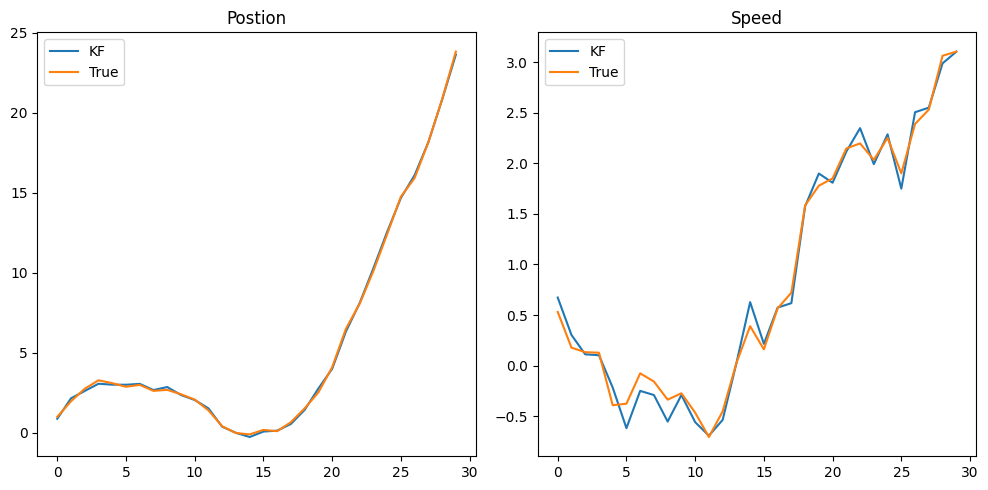

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data
df = pd.read_excel(r"C:\Users\huawei\Desktop\KF.xlsx",header = None)
Z1 = df.iloc[1:,0].values
Z2 = df.iloc[1:,1].values

Z_measure_list = []
Z_measure_list = [[[Z1[i]],[Z2[i]]] for i in range(len(Z1))]
Z_measure_list = np.array(Z_measure_list)

A = np.mat([[1,1],
            [0,1]])
H = np.eye(2)
I = np.eye(2)  # 单位阵
Q = np.eye(2)  # 过程噪声
R = np.mat([[0.1,0],
            [0,0.1]]) # 测量噪声

# 产生随机误差
def Error(var):
    return np.random.normal(loc=0.0,scale=var,size=None)

# 初始化
X0_hat = np.mat([[0],
                 [1]]) # 初始位置和速度
P0_hat = np.mat([[1,0],
                [0,1]]) # 状态估计协方差矩阵P初始化

X_hat_list = []
X_true_list = []
P_ture_list = []
P_hat_list = []

P_hat_list.append(P0_hat)
X_hat_list.append(X0_hat)


for k in range(30):
    # 过程噪声
    w = np.array([[Error(Q[0,0])],
                  [Error(Q[1,1])]])
    # 测量噪声
    v = np.array([[Error(R[0,0])],
                  [Error(R[1,1])]])

    P_hat = P_hat_list[k]
    # 卡尔曼增益
    k1 = P_hat @ H.T
    k2 = np.linalg.inv(H @ P_hat @ H.T + R)
    K = k1 @ k2

    P = (I - K @ H) @ P_hat
    P_next_hat = A @ P @ A.T + Q

    P_hat_list.append(P_next_hat)
    P_ture_list.append(P)

    Z = Z_measure_list[k] + v
    X_hat = X_hat_list[k] + w
    X = X_hat + K @ (Z - H @ X_hat)
    X_next_hat = A @ X 

    X_hat_list.append(X_next_hat)
    X_true_list.append(X)

X_true_list = np.array(X_true_list)

# 绘图
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 创建子图

# 位置
axs[0].plot(X_true_list[:, 0], label='KF')
axs[0].plot(Z_measure_list[:, 0], label='True')
axs[0].set_title('Postion')
axs[0].legend()

# 速度
axs[1].plot(X_true_list[:, 1], label='KF')
axs[1].plot(Z_measure_list[:, 1], label='True')
axs[1].set_title('Speed')
axs[1].legend()

plt.tight_layout()
plt.show()
